### You should have trained your network before running this notebook

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision.utils as vutils
import torchvision.models as models
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

In [2]:
import sys
sys.path.append('../deep/')
from classes import *

In [3]:
cc = ConsumerClassifier()
cc.load_state_dict(torch.load('../runs/recent_training.pt'))

Lets take a look at our unsupervised categories, and perhaps some of the jokes highest rated (and least highest rated) for a perfect categorical match.

Maybe we could classify the person as liking dark humor, politics, puns, sexist, nerdy... the list goes on!  But perhaps for the moment we don't even really care if we know the category of the jokes, just that we have some blind classifications.

In [4]:
N = 5
def showJoke(idx):
    fname = '../dat/jokes/init{}.html'.format(idx+1)
    display(HTML(fname))

for i in range(N):
    x = torch.zeros(N)
    x[i] = 1.0
    y = cc.predict(Variable(x)).data.numpy()
    
    print("Embedding {}:".format(i))
    print("    Best Joke:", np.argmax(y))
    showJoke(np.argmax(y))
    print("   Worst Joke:", np.argmin(y))
    showJoke(np.argmin(y))
    print("--------------------------------")

Embedding 0:
    Best Joke: 67


   Worst Joke: 0


--------------------------------
Embedding 1:
    Best Joke: 3


   Worst Joke: 7


--------------------------------
Embedding 2:
    Best Joke: 67


   Worst Joke: 15


--------------------------------
Embedding 3:
    Best Joke: 34


   Worst Joke: 79


--------------------------------
Embedding 4:
    Best Joke: 29


   Worst Joke: 25


--------------------------------


OK, cool.  Real fast, we have (at this time) 5 categories.  Lets see if there is much correlation between the joke ratings and the categories?

We'll iterate through all category pairs, sort joke ratings from low to high for the first, then show the joke rating of the second on top.

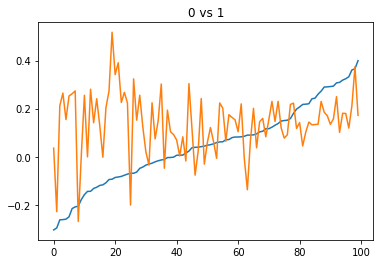

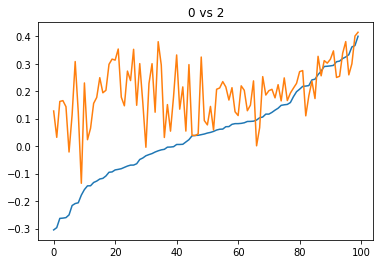

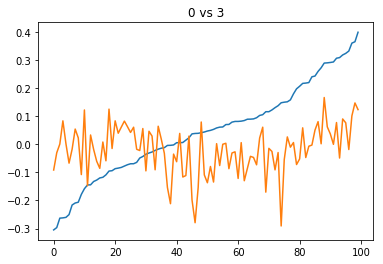

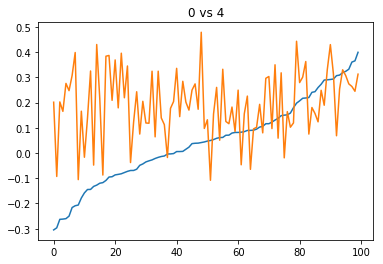

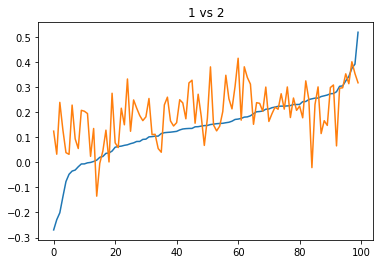

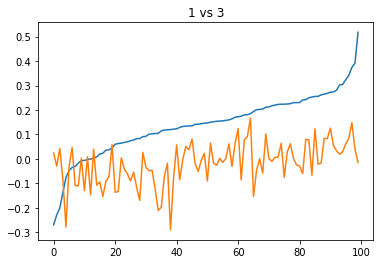

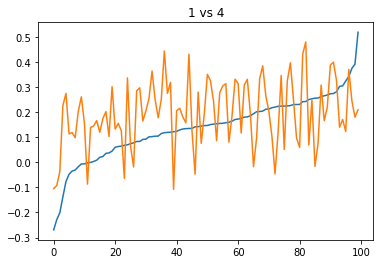

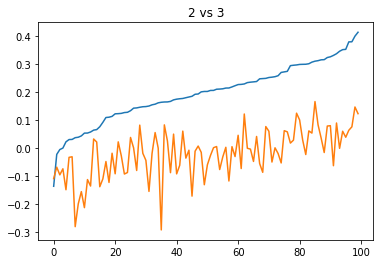

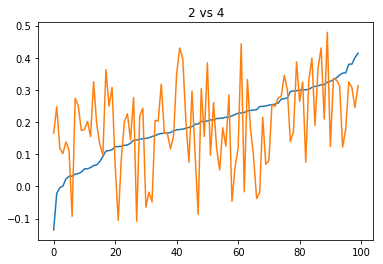

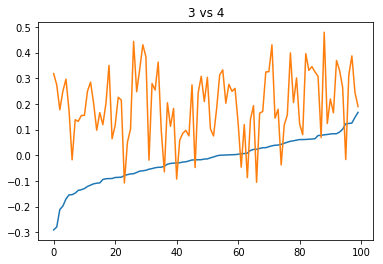

In [5]:
from itertools import combinations
p = []
for i in range(N):
    x = torch.zeros(N)
    x[i] = 1.0
    y = cc.predict(Variable(x)).data.numpy()
    p.append(y)

for (a,b) in combinations(range(N), 2):
    order = np.argsort(p[a])
    plt.plot(p[a][order], label=str(a))
    plt.plot(p[b][order], label=str(b))
    plt.title("{} vs {}".format(a,b))
    plt.show()

Looks... pretty different to me :).

Lets see what our individual classifier comes up with.

In [6]:
#load one of the datasets for exploration.
df = pd.read_excel('../dat/jester-data-1.xls', 
        names = ['num'] + ['joke_{}'.format(i) for i in range(100)],
        dtype=np.float32)

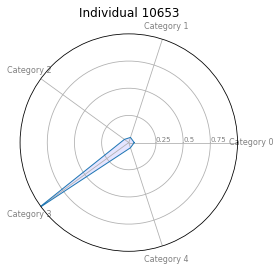

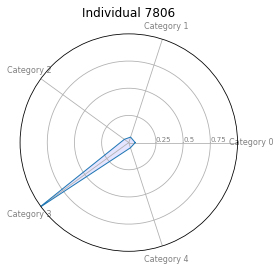

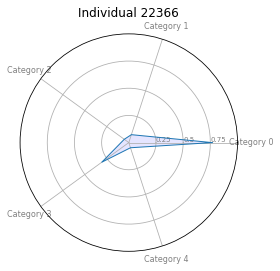

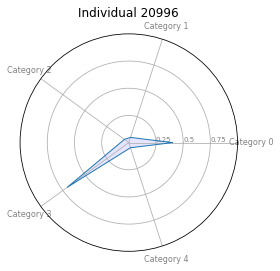

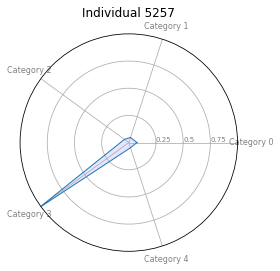

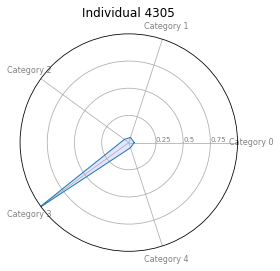

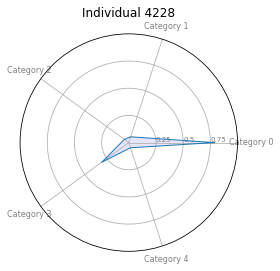

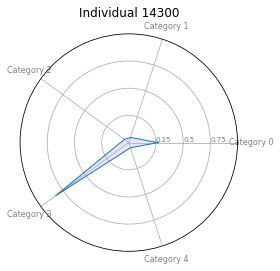

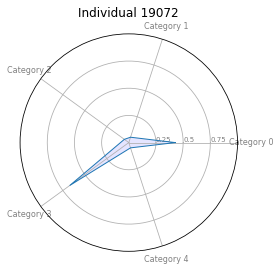

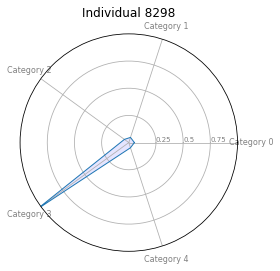

In [7]:
#spider / radar plot looks pretty cool (credit to python-graph-gallery.com)
def spider(df, row):
    x = Variable(torch.from_numpy(df.loc[row].values[1:]))
    y = torch.exp(cc.classify(x)).data.numpy()
    
    #add a little thickness or the plot just doesn't look good
    y += 0.05
    
    categories = ["Category {}".format(i) for i, _ in enumerate(y)]
    N = len(categories)
    
    #prepare to draw a line, coming back to start
    values = list(y) + [y[0]]
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    #prepare for a polar plot
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color='grey', size=7)
    plt.ylim(0,1.0)
    
    #plot lines and fill
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles,values,'b', alpha=0.1)
    
    plt.title("Individual {}".format(row))
    plt.show()
    
    
for _ in range(10):
    i = np.random.randint(df.shape[0])
    spider(df,i)

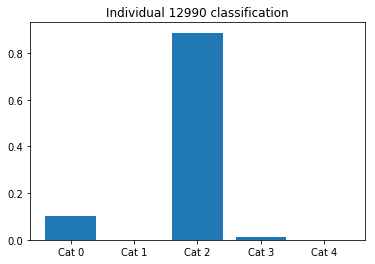

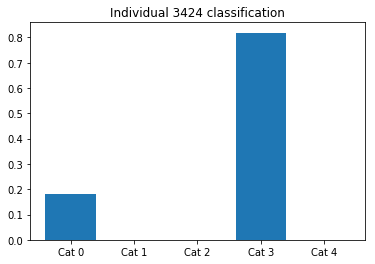

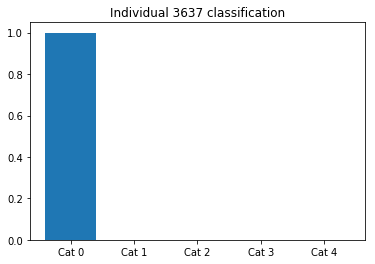

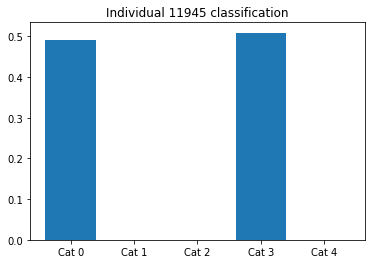

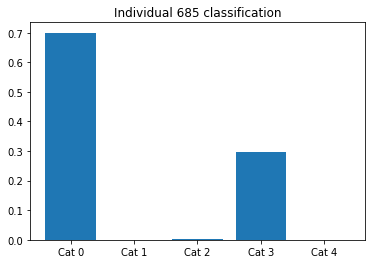

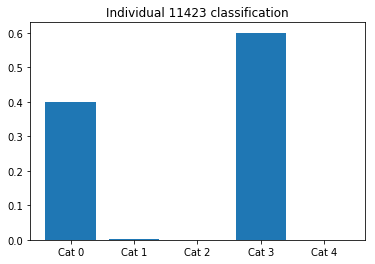

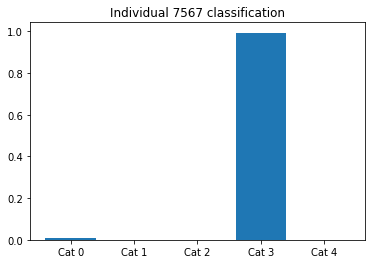

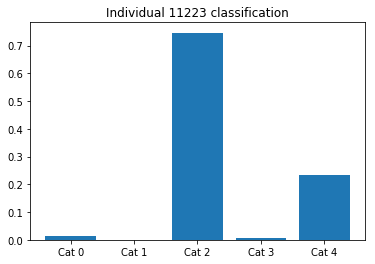

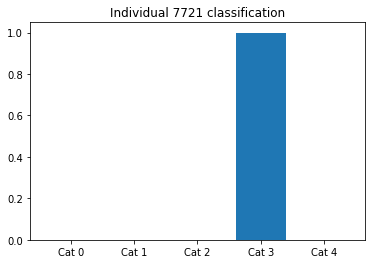

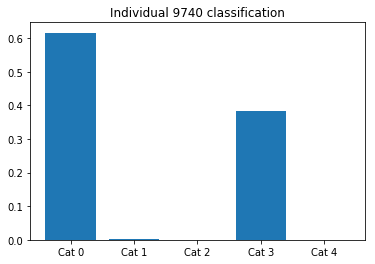

In [8]:
#could also do a more classic bar chart representation
def barChart(df, row):
    x = Variable(torch.from_numpy(df.loc[row].values[1:]))
    y = torch.exp(cc.classify(x)).data.numpy()
    
    categories = ["Cat {}".format(i) for i, _ in enumerate(y)]

    plt.bar(categories, y)
    plt.title("Individual {} classification".format(row))
    plt.show()

for _ in range(10):
    i = np.random.randint(df.shape[0])
    barChart(df,i)

It looks like "Category 3" is the most common category, with many people fitting strongly in.
Cool!